# Visual bag of words (VBOW) detection of Western blot duplicates

Here we walk through the process of loading a Western blot image, identifying salient features, and testing it against a library of other Western blots to see if any look similar. Then, we'll manipulate the image in an effort to make it harder to identify as a duplicate, and show that it is still identified.

In [1]:
# import dependencies
import numpy as np
import cv2
import matplotlib
% matplotlib inline
from matplotlib import pyplot as plt
import sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
import skimage.io
from skimage.color import rgb2gray
import os
import pandas as pd
import random
from vbow_utils import normalize_image, hash_features, compare_hashes
import pickle

Now we'll load in a test Western blot image. Here it is:
  
 <img src="sample_gel/121f5_2.jpg" alt="Drawing" style="width: 500px;"/>

In [2]:
test_im = skimage.io.imread('sample_gel/121f5_2.jpg')

Next, we identify salient features using the ORB and SIFT feature detectors.

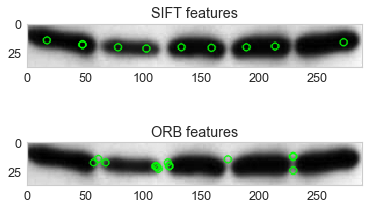

In [3]:
# initialize the feature detectors to find salient features
orb_detector = cv2.ORB_create(nfeatures=20, edgeThreshold=10, patchSize=10)
sift_detector = cv2.xfeatures2d.SIFT_create(nfeatures=40)

norm_im = normalize_image(test_im)

# find the keypoints with ORB and SIFT
ORB_kp = orb_detector.detect(norm_im, None)
SIFT_kp = sift_detector.detect(norm_im, None)

# compute the descriptors with ORB and SIFT
ORB_kp, ORB_des = orb_detector.compute(norm_im, ORB_kp)
SIFT_kp, SIFT_des = sift_detector.compute(norm_im, SIFT_kp)

# draw only keypoints location,not size and orientation
SIFT_kp_im = cv2.drawKeypoints(norm_im,SIFT_kp,None,color=(0,255,0), flags=0)
ORB_kp_im = cv2.drawKeypoints(norm_im,ORB_kp,None,color=(0,255,0), flags=0)
f, axarr = plt.subplots(2,1)
axarr[0].imshow(SIFT_kp_im)
axarr[0].set_title('SIFT features')
axarr[0].grid(False)
axarr[1].imshow(ORB_kp_im)
axarr[1].set_title('ORB features')
axarr[1].grid(False)

Notably, these two types of feature detectors identify complementary types of features, and therefore can be combined to generate a more complete set.

Previously, I performed this processing on 10,000 gel images to generate 100,000 SIFT feature labels and 200,000 ORB feature labels (a "dictionary" of SIFT/ORB label "words", if you will). Upon doing so, I clustered each set of labels into 500 distinct clusters using KMeans clustering. We then generate a hash of which feature groups are present based on which cluster the identified features most closely fit with, and count the number of features of each type.

In [4]:
# load the pre-trained K-Means clustering models
with open('../kmeans_models/ORB_kmeans.pkl', 'rb') as f:
    ORB_kmeans = pickle.load(f)
f.close()
with open('../kmeans_models/SIFT_kmeans.pkl', 'rb') as f:
    SIFT_kmeans = pickle.load(f)
f.close()

# calculate the cluster each feature corresponds to and generate a hashed output
ORB_hash = hash_features(ORB_des, ORB_kmeans, n_clusters=500)
SIFT_hash = hash_features(SIFT_des, SIFT_kmeans, n_clusters=500)

# merge the two hashes to generate a 1000-cluster hash vector of both ORB and SIFT
full_hash = np.hstack((ORB_hash, SIFT_hash))

Computing label assignment and total inertia
Computing label assignment and total inertia


Now that we have the fully hashed version of our image, we can measure its similarity to a library of other hashed Western blot images (in this case, 1000 different Westerns pulled out of figures - see the Western Detection notebook for details.) We then convert the hash vector into a logical present/absent vector for each cluster (rather than counting the number of occurences of each feature), and generate a similarity metric defined as the intersection of the hashes divided by the union of the hashes: $$\text{similarity}=\frac{\sum a\cap b}{\sum a \cup b}$$

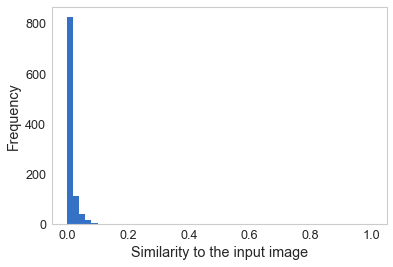

In [5]:
# loading in a library of hashed Western blots
hash_library = np.load('../hashed_westerns/western_hash_library.npy')
similarities = compare_hashes(full_hash, hash_library)

# plot a histogram to show the similarity between the image and the others in the library
plt.hist(similarities, bins=50, range=(0,1))
plt.xlabel('Similarity to the input image')
plt.ylabel('Frequency')
plt.grid(False)

As we can see, none of the images in the library are very similar (the highest score is 0.12). By contrast, if we tested the image hash against itself, its score would be 1.

Now, let's generate a manipulated version of the input image by:
1. Rotating it
2. Cutting off the maximum intensity pixels
3. Flipping it horizontally

Text(0.5,1,'Altered duplicate')

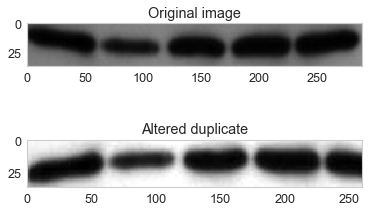

In [30]:
altered_image = np.flip(test_im, axis=0) # flip it across the x axis
altered_image = np.flip(test_im, axis=1) # flip it across the y axis
altered_image = np.rot90(altered_image, k=2)  # rotate 180 degrees
altered_image = altered_image.astype('uint16')*2  # linear contrast adjustment
altered_image[altered_image > 255] = 255  # non-linear contrast adjustment
altered_image = altered_image[:, 0:260, :].astype('uint8')  # crop

f, axarr = plt.subplots(2, 1)
axarr[0].imshow(test_im, cmap='gray')
axarr[0].grid(False)
axarr[0].set_title('Original image')
axarr[1].imshow(altered_image, cmap='gray')
axarr[1].grid(False)
axarr[1].set_title('Altered duplicate')

Now we'll generate a hash for the altered version and compare it to the original.

In [31]:
altered_im = normalize_image(altered_image)

# find the keypoints with ORB and SIFT
alt_ORB_kp = orb_detector.detect(altered_im, None)
alt_SIFT_kp = sift_detector.detect(altered_im, None)

# compute the descriptors with ORB and SIFT
alt_ORB_kp, alt_ORB_des = orb_detector.compute(altered_im, alt_ORB_kp)
alt_SIFT_kp, alt_SIFT_des = sift_detector.compute(altered_im, alt_SIFT_kp)

# calculate the cluster each feature corresponds to and generate a hashed output
alt_ORB_hash = hash_features(alt_ORB_des, ORB_kmeans, n_clusters=500)
alt_SIFT_hash = hash_features(alt_SIFT_des, SIFT_kmeans, n_clusters=500)

# merge the two hashes to generate a 1000-cluster hash vector of both ORB and SIFT
alt_full_hash = np.hstack((alt_ORB_hash, alt_SIFT_hash))

# compare the two
similarity = compare_hashes(alt_full_hash, full_hash[np.newaxis, :])

print('Similarity score between the images: ' + str(similarity[0]))

Computing label assignment and total inertia
Computing label assignment and total inertia
Similarity score between the images: 0.47058823529411764


## This similarity score is ~4x the score yielded for any unrelated image in the library!